In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import pdb

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [2]:
diamonds_df = pd.read_csv('diamonds.csv')

In [3]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


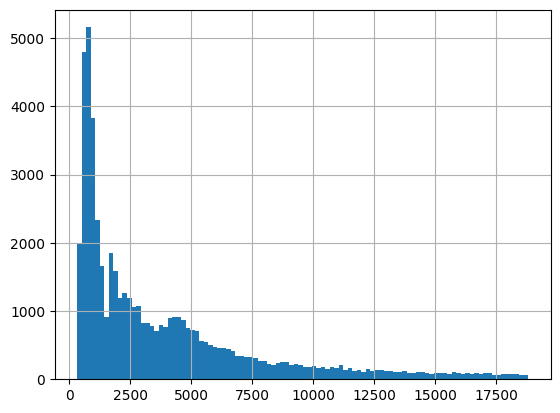

In [4]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [5]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [6]:
print([1,2])

[1, 2]


In [7]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [8]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [9]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,4,1,1,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,3,5,3,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,1,6,1,63.3,58.0,335,4.34,4.35,2.75


In [10]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [11]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [13]:
reg = LinearRegression().fit(X_train, y_train)

In [14]:
y_pred = reg.predict(X_test)

In [15]:
score = r2_score(y_pred, y_test)

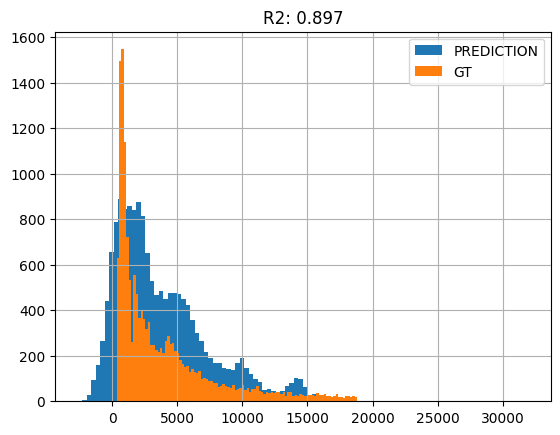

In [16]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

In [17]:
class SigmoidLayer:
    def __init__(self) -> None:
        pass
    def forward(self,X):
        self.y = 1.0/(1 + np.exp(-X))
        return self.y
    def backward(self,dLdy):
        return dLdy * self.y * (1 - self.y)
    def step(self):
        pass

In [18]:
class ReluLayer: # Not used made just for fun
    def __init__(self) -> None:
        pass
    def forward(self,X):
        return np.multiply((X>0),X)
    def backward(self,dLdy):
        return (dLdy>0) * 1
    def step(self):
        pass

In [19]:
class LinearLayer:
    def __init__(self, input_size,output_size,l_r):
        self.W = np.random.randn(input_size,output_size) 
        self.b = np.random.randn(output_size) 
        self.l_r = l_r
        
    
    def forward(self, X):
        self.X = X
        #print(X.shape, self.W.shape)
        self.Y = X @ self.W + self.b
        return self.Y
    
    def backward(self, dLdy):
        dydw = self.W
        #X [N,input,1]
        #dLdy [N,1,output]
        #print('before = ',self.X.shape,dLdy.shape)
        self.dLdw = self.X.T @  dLdy # Because it is 3D matrix
        #print('after = ',np.expand_dims(self.X, -1).shape,np.expand_dims(dLdy, -2).shape)
        #print('dLdw = ',self.dLdw)
        #pdb.set_trace()
        
        
        self.dLdb = dLdy # as dy/db == 1
          
        
        if len(self.dLdb) > 1:
             self.dLdb = self.dLdb.sum(axis=0)
        #pdb.set_trace()
        dLdx = dLdy @ self.W.T
        #print('dLdx=',dLdx)
        return dLdx
    def step(self):
        self.W -= self.dLdw * self.l_r
        self.b -= self.dLdb * self.l_r

## Проверяем верный рассчет градиента линейного слоя

In [20]:
def check_gradient(f,x,eps = 1e-6):
    y = np.ones(x.shape)
    for i in range(x.shape[0]):
            if (len(x.shape) > 1):
                for j in range(x.shape[1]):
                    x[i,j] += eps
                    f_plus = f(x)
                    x[i][j] -= 2 * eps
                    f_minus = f(x)
                    x[i][j] += eps

                    y[i][j] = (f_plus - f_minus) / (2 * eps)
            else:
                    x[i] += eps
                    f_plus = f(x)
                    x[i] -= 2 * eps
                    f_minus = f(x)
                    x[i] += eps

                    y[i] = (f_plus - f_minus) / (2 * eps)
    return y

test_x = np.array([[1.2, 3.4, 5.6],[7.8,8.9,9.1]])
linearTest = LinearLayer(3,2,0.1)
linearTest.forward(test_x)
def f(W,x=test_x):
      return linearTest.forward(x).sum()
    
check_gradient(f, linearTest.W)

array([[ 9. ,  9. ],
       [12.3, 12.3],
       [14.7, 14.7]])

In [21]:

linearTest.backward(np.ones(2))
print(linearTest.dLdw)

[ 9.  12.3 14.7]


In [22]:
class MSELOSS:
    def __init__(self) -> None:
        pass
    def forward(self,y,y_res):
        self.n = y.shape[0]
        #print(y.shape,y_res.shape)
        self.diff = y_res - y
        #print(self.diff.shape)
        self.L = (self.diff ** 2).mean()
        return self.L
    def backward(self):
        dLdy =   (-1 / self.n) * (2 * self.diff)
        return dLdy
    def step():
        pass



In [52]:
class MLPRegressor:
    def __init__(
        self,
        hidden_layer_sizes=(100,100),
        learning_rate=1e-6,
        max_iter=100,
        layers = None,
        loss = None
    ):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.hidden_layer_sizes = hidden_layer_sizes
        self.layers = layers
        self.loss = loss
        
        self.layers = []
        
        for i in range(1,len(hidden_layer_sizes)):
            self.layers.append(LinearLayer(hidden_layer_sizes[i-1],hidden_layer_sizes[i],learning_rate))
            self.layers.append(SigmoidLayer())
        # Задача регрессии - нужен один ответ для каждого элемента
        self.layers.append(LinearLayer(hidden_layer_sizes[-1],1,learning_rate))

        if (self.loss == None):
            self.loss = MSELOSS()
    
    def train(self, X, y):
        losses = []
        saved_X = X.copy()
        for i in range(self.max_iter):
            X = saved_X
            for layer in self.layers:
                X = layer.forward(X)
                #print(f'X =={X}',X)
            #print(X.shape)
            L = self.loss.forward(X,y) # On last interation the input will be the result
            print('L=',L)
            losses.append(L)
            dLdy = self.loss.backward() 
            #dLdy = L
            #print('shape.loss==',dLdy.shape)
            for layer in self.layers[::-1]:
                dLdy = layer.backward(dLdy)

            for layer in self.layers:
                layer.step()
        return losses

    def predict(self, X):
        for layer in self.layers:
                X = layer.forward(X)
        return X

# Тестируем гридиент MSE


In [53]:
TestMSELOSS = MSELOSS()
chosen_size = 50
test_y = np.random.rand(chosen_size,1)
test_y_res = np.random.rand(chosen_size,1)
TestMSELOSS.forward(test_y,test_y_res)
def f_loss(W,y=test_y,y_res = test_y_res):
      return TestMSELOSS.forward(y,y_res).sum()
check_gradient(f_loss, test_y_res)

array([[ 0.00539405],
       [-0.01615052],
       [-0.01385113],
       [-0.03536263],
       [-0.00332506],
       [ 0.02783565],
       [-0.00473476],
       [-0.00439181],
       [-0.00928935],
       [-0.03271515],
       [ 0.00636483],
       [ 0.01997185],
       [ 0.01213123],
       [ 0.00990846],
       [-0.01344335],
       [-0.0273569 ],
       [ 0.0243664 ],
       [-0.02203727],
       [ 0.00864599],
       [ 0.03113672],
       [ 0.00633782],
       [ 0.01599262],
       [-0.01932463],
       [ 0.01531918],
       [-0.01189549],
       [ 0.00721729],
       [-0.02888533],
       [-0.00917492],
       [ 0.01043284],
       [ 0.00301055],
       [ 0.00148741],
       [-0.01528526],
       [-0.00408925],
       [-0.01343126],
       [-0.01101918],
       [-0.01879822],
       [ 0.02617115],
       [-0.01393076],
       [ 0.00116747],
       [-0.01462075],
       [-0.00668656],
       [ 0.01080312],
       [-0.00616743],
       [ 0.00325392],
       [ 0.00022313],
       [ 0

In [54]:
test_y,test_y_res

(array([[5.10263805e-01],
        [6.84151837e-01],
        [5.25134793e-01],
        [9.81753348e-01],
        [4.82683513e-01],
        [2.87097719e-01],
        [5.65222734e-01],
        [5.94964499e-01],
        [5.78201845e-01],
        [9.18802099e-01],
        [5.45276331e-01],
        [2.15345052e-01],
        [1.80473373e-04],
        [5.34050110e-01],
        [7.74711698e-01],
        [9.99320201e-01],
        [3.39915585e-01],
        [6.98361296e-01],
        [2.68041799e-01],
        [2.62004678e-02],
        [9.71196130e-02],
        [5.98560090e-01],
        [6.05100387e-01],
        [1.29969253e-01],
        [7.53717863e-01],
        [3.39089944e-01],
        [9.11234077e-01],
        [3.62372635e-01],
        [2.54008758e-01],
        [5.39424414e-01],
        [5.18367779e-01],
        [3.83400850e-01],
        [5.06148364e-01],
        [6.69873578e-01],
        [3.05488529e-01],
        [7.94166519e-01],
        [1.65658358e-01],
        [9.24115478e-01],
        [6.3

In [55]:
TestMSELOSS.backward()

array([[-0.00539405],
       [ 0.01615052],
       [ 0.01385113],
       [ 0.03536263],
       [ 0.00332506],
       [-0.02783565],
       [ 0.00473476],
       [ 0.00439181],
       [ 0.00928935],
       [ 0.03271515],
       [-0.00636483],
       [-0.01997185],
       [-0.01213123],
       [-0.00990846],
       [ 0.01344335],
       [ 0.0273569 ],
       [-0.0243664 ],
       [ 0.02203727],
       [-0.00864599],
       [-0.03113672],
       [-0.00633782],
       [-0.01599262],
       [ 0.01932463],
       [-0.01531918],
       [ 0.01189549],
       [-0.00721729],
       [ 0.02888533],
       [ 0.00917492],
       [-0.01043284],
       [-0.00301055],
       [-0.00148741],
       [ 0.01528526],
       [ 0.00408925],
       [ 0.01343126],
       [ 0.01101918],
       [ 0.01879822],
       [-0.02617115],
       [ 0.01393076],
       [-0.00116747],
       [ 0.01462075],
       [ 0.00668656],
       [-0.01080312],
       [ 0.00616743],
       [-0.00325392],
       [-0.00022313],
       [-0

In [56]:
len(features)

9

# Проверяем модель MLP на выборке Diamonds

In [57]:
mlpRegressorTest = MLPRegressor(hidden_layer_sizes=(2,3,5))
a = np.array([[1.2,3.2],[3.4,5.6]])
b = np.array([1.3,2.3]).reshape(-1,1)

In [58]:
print(mlpRegressorTest.layers[0].W)
#mlpRegressorTest.layers[0].dLdw

[[-0.23628499  0.56962804  0.96586569]
 [-1.26984339  1.19038212 -0.27679261]]


In [59]:
mlpRegressorTest.train(a,b)


L= 3.8207325685872515
L= 3.820704231557775
L= 3.8206758947322115
L= 3.8206475581105606
L= 3.8206192216928185
L= 3.8205908854789854
L= 3.82056254946906
L= 3.82053421366304
L= 3.8205058780609256
L= 3.8204775426627133
L= 3.8204492074684024
L= 3.8204208724779924
L= 3.8203925376914833
L= 3.8203642031088716
L= 3.820335868730155
L= 3.8203075345553343
L= 3.820279200584408
L= 3.8202508668173722
L= 3.82022253325423
L= 3.820194199894975
L= 3.820165866739611
L= 3.8201375337881327
L= 3.8201092010405393
L= 3.8200808684968313
L= 3.8200525361570064
L= 3.8200242040210632
L= 3.819995872089
L= 3.819967540360816
L= 3.8199392088365096
L= 3.819910877516078
L= 3.8198825463995227
L= 3.819854215486841
L= 3.819825884778032
L= 3.819797554273092
L= 3.8197692239720222
L= 3.8197408938748207
L= 3.8197125639814864
L= 3.819684234292016
L= 3.8196559048064107
L= 3.8196275755246676
L= 3.8195992464467867
L= 3.819570917572766
L= 3.819542588902603
L= 3.8195142604362977
L= 3.8194859321738477
L= 3.819457604115253
L= 3.8194292

[3.8207325685872515,
 3.820704231557775,
 3.8206758947322115,
 3.8206475581105606,
 3.8206192216928185,
 3.8205908854789854,
 3.82056254946906,
 3.82053421366304,
 3.8205058780609256,
 3.8204775426627133,
 3.8204492074684024,
 3.8204208724779924,
 3.8203925376914833,
 3.8203642031088716,
 3.820335868730155,
 3.8203075345553343,
 3.820279200584408,
 3.8202508668173722,
 3.82022253325423,
 3.820194199894975,
 3.820165866739611,
 3.8201375337881327,
 3.8201092010405393,
 3.8200808684968313,
 3.8200525361570064,
 3.8200242040210632,
 3.819995872089,
 3.819967540360816,
 3.8199392088365096,
 3.819910877516078,
 3.8198825463995227,
 3.819854215486841,
 3.819825884778032,
 3.819797554273092,
 3.8197692239720222,
 3.8197408938748207,
 3.8197125639814864,
 3.819684234292016,
 3.8196559048064107,
 3.8196275755246676,
 3.8195992464467867,
 3.819570917572766,
 3.819542588902603,
 3.8195142604362977,
 3.8194859321738477,
 3.819457604115253,
 3.819429276260511,
 3.8194009486096205,
 3.81937262116258

In [139]:
mlpRegressor = MLPRegressor(hidden_layer_sizes=(len(features),100),learning_rate=1e-4,max_iter=3000)

In [140]:
print(X_train)

[[0.05197505 0.75       0.83333333 ... 0.45623836 0.08285229 0.09685535]
 [0.31185031 1.         0.33333333 ... 0.7122905  0.12852292 0.14937107]
 [0.07068607 1.         0.16666667 ... 0.49068901 0.08981324 0.10062893]
 ...
 [0.07276507 0.5        0.33333333 ... 0.49255121 0.09032258 0.10125786]
 [0.07068607 1.         0.33333333 ... 0.49068901 0.08913413 0.10125786]
 [0.03950104 0.75       0.5        ... 0.44134078 0.07962649 0.09025157]]


In [141]:
mlpRegressor.layers[0].W

array([[ 1.78309288e+00,  6.71946569e-01,  1.36212910e+00,
         3.17745144e-01, -6.46753236e-02,  1.02769633e+00,
         1.47344158e+00, -3.11875416e-01,  3.00503444e-02,
         1.93283795e+00,  7.17724678e-01,  1.86973107e+00,
        -1.38272538e+00,  1.28496325e-01, -8.34219037e-01,
        -1.31758155e+00,  1.05030402e+00, -6.75647767e-02,
        -2.94677492e-01, -5.02899148e-01, -8.64107618e-01,
         1.05034398e+00,  2.55987769e-01, -1.57862013e+00,
        -1.93181276e-01,  5.85082943e-01, -8.40166017e-01,
         5.10476272e-01,  1.20970294e+00,  2.54229436e+00,
         5.87325376e-01,  7.99899493e-01, -6.37572297e-01,
        -1.40510934e+00,  4.99162918e-01, -1.39375055e+00,
         6.85261279e-01, -1.51677382e+00,  9.67571109e-01,
         1.64269115e+00, -8.64516032e-01,  9.26831123e-01,
         1.79089363e-01, -1.04009014e+00,  8.09123672e-01,
         7.06175165e-01,  1.42857276e+00, -7.02259182e-01,
         1.35572902e+00, -6.04039728e-01, -3.04495492e-0

In [142]:
losses_mlp = mlpRegressor.train(X_train,y_train)

L= 31513361.658896543


L= 31259912.74736507
L= 30995004.60688813
L= 30707148.307418644
L= 30394291.822154112
L= 30056114.96135204
L= 29695123.910768624
L= 29316671.37830012
L= 28927539.87838238
L= 28531810.06120174
L= 28133848.237910666
L= 27739710.539011847
L= 27352730.674856044
L= 26972933.402105786
L= 26600723.28781419
L= 26237249.809276577
L= 25882459.01927029
L= 25536838.488246944
L= 25200578.94209406
L= 24874117.052305102
L= 24557745.12356057
L= 24251321.53087129
L= 23954689.669928364
L= 23667909.981362946
L= 23391115.38194375
L= 23124132.55933117
L= 22866604.860008955
L= 22618142.75912614
L= 22378340.44275454
L= 22146754.62144512
L= 21922877.391079787
L= 21706148.186817925
L= 21496115.364975918
L= 21292747.861081712
L= 21096415.06608607
L= 20907286.181180403
L= 20725152.151698757
L= 20549716.909781035
L= 20380707.57977652
L= 20217875.391873725
L= 20060987.847615123
L= 19909824.33331784
L= 19764173.929192137
L= 19623834.23343566
L= 19488610.648631286
L= 19358315.888054688
L= 19232769.592947677
L= 19111

In [143]:
y_pred_mlp = mlpRegressor.predict(X_test)


In [144]:
mlpRegressor.layers[0].W

array([[ 4.27261687e+01,  4.40888392e+01,  4.68798095e+01,
         3.00565617e+01,  4.18809875e+01,  4.46085040e+01,
         4.61272401e+01,  3.76646155e+01,  4.28806544e+01,
         4.72970978e+01,  4.24951043e+01,  4.65765566e+01,
         1.21764020e+01,  3.74156188e+01, -1.32978821e+00,
         4.11075311e+00,  3.87620846e+01,  4.07383059e+01,
         4.31243783e+01,  3.23981765e+01,  1.71604979e+00,
         4.31751554e+01, -3.56302535e-01,  9.01078307e+00,
         2.27409487e+01,  3.82497383e+01,  2.95248046e+01,
         4.06419163e+01,  4.66175110e+01,  4.75784336e+01,
         4.36728286e+01,  4.48152926e+01,  2.58762677e+01,
         2.67841460e+01,  4.42527990e+01,  1.28931976e+01,
         3.29138911e+01,  2.95051445e+01,  4.25068666e+01,
         4.30192378e+01,  2.97675807e+01,  4.32973151e+01,
         4.08900621e+01,  2.81250630e+01,  4.47393157e+01,
         3.96706107e+01,  4.41040517e+01,  1.21998707e+01,
         3.60573025e+01,  3.15440982e+01,  2.94924817e+0

In [145]:
score_mlp = r2_score(y_pred_mlp, y_test)

In [146]:
print(y_pred_mlp)

[[1248.13943473]
 [ 909.74662902]
 [ 725.01170061]
 ...
 [ 617.85145453]
 [4585.69168358]
 [ 964.11148378]]


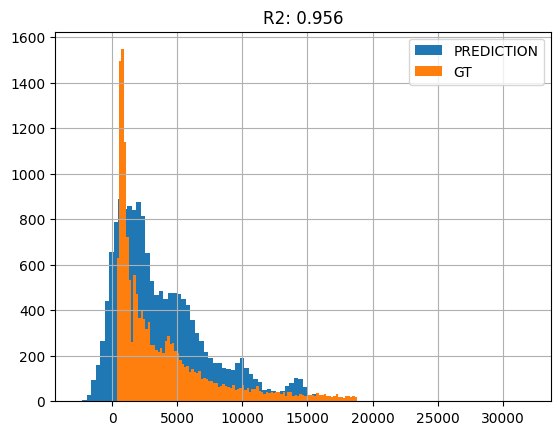

In [147]:
plt.title(f'R2: {str(score_mlp)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid()

# График Loss-a

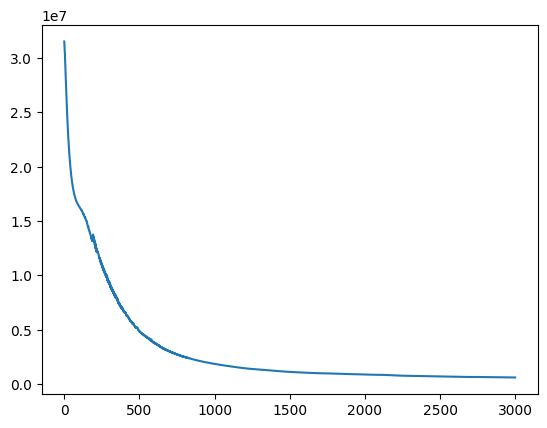

In [148]:
plt.plot(losses_mlp)
plt.show()

In [149]:
print(losses_mlp)
losses_mlp[-1]

[31513361.658896543, 31259912.74736507, 30995004.60688813, 30707148.307418644, 30394291.822154112, 30056114.96135204, 29695123.910768624, 29316671.37830012, 28927539.87838238, 28531810.06120174, 28133848.237910666, 27739710.539011847, 27352730.674856044, 26972933.402105786, 26600723.28781419, 26237249.809276577, 25882459.01927029, 25536838.488246944, 25200578.94209406, 24874117.052305102, 24557745.12356057, 24251321.53087129, 23954689.669928364, 23667909.981362946, 23391115.38194375, 23124132.55933117, 22866604.860008955, 22618142.75912614, 22378340.44275454, 22146754.62144512, 21922877.391079787, 21706148.186817925, 21496115.364975918, 21292747.861081712, 21096415.06608607, 20907286.181180403, 20725152.151698757, 20549716.909781035, 20380707.57977652, 20217875.391873725, 20060987.847615123, 19909824.33331784, 19764173.929192137, 19623834.23343566, 19488610.648631286, 19358315.888054688, 19232769.592947677, 19111798.009397816, 18995233.699137073, 18882915.270391528, 18774687.120411213,

610099.740790363